In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.constants import mu_0, epsilon_0
from scipy import fftpack
from scipy import sparse
from scipy.special import factorial
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d, CubicSpline, BSpline
from scipy.sparse import csr_matrix, csc_matrix
import csv
from scipy.special import roots_legendre, eval_legendre
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.linalg import lu_factor, lu_solve
from scipy import signal
import ipywidgets
import discretize
import  os
import json
from PIL import Image
import seaborn as sns
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import ipywidgets as widgets
import string
eps = np.finfo(float).eps

In [2]:
import empymod
from masa_utils import PsuedoLog
from masa_utils import Pelton_res_f, DDR_f
from masa_utils import InducedPolarizationSimulation 
from masa_utils import Optimization 
from masa_utils import empymod_IP_simulation
from masa_utils import TEM_Signal_Process


Simulatin and synthetic study on deep sea hydrothermal deposits explortaion using WISTEM (K. Nakayama and A. Saito, 2016) (K.Nakayama M. Motoori and A. Saito,2019). On-Time: 200msec ramp time: 200usec Transmitter Loop: 3.5m Square Loop Receiver Loop: Coincident-type Number of Turn: 5 3.5m rectangular loop has equivalent area for 2.0m circular loop.

In [3]:
base_freq=1.25
on_time=0.2
rmp_time=200e-6
rec_time=3e-2
smp_freq=50e3 #200e3  

In [4]:
tx_side = 3.5
tx_radius = (tx_side)/(np.sqrt(np.pi))
tx_circumeference = 2*np.pi*tx_radius
tx_surface = np.pi*tx_radius**2
n_turns = 5
tx_depth = 0
print(f"Transmitter radius: {tx_radius}")

Transmitter radius: 1.9746635424171473


In [5]:
tstrt, tend = 1e-4, 3e-2
logstep = 1/15
WISTEM_SP_sim = TEM_Signal_Process(
    # base_freq=base_freq,
    # on_time=on_time, 
    rmp_time=rmp_time, 
    rec_time=tend, 
    smp_freq=smp_freq
)


In [6]:
times_sim = WISTEM_SP_sim.times_rec
times_clc = WISTEM_SP_sim.times_rec
ntimes = len(times_clc)
print(ntimes)
print(times_clc[:3], times_clc[-3:])
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
windows_strt = WISTEM_SP_sim.windows_strt
windows_cen = WISTEM_SP_sim.windows_cen
windows_end = WISTEM_SP_sim.windows_end
print(windows_cen-rmp_time)

1500
[2.e-05 4.e-05 6.e-05] [0.02996 0.02998 0.03   ]
[0.0001     0.00011659 0.00013594 0.00015849 0.00018478 0.00021544
 0.00025119 0.00029286 0.00034145 0.00039811 0.00046416 0.00054117
 0.00063096 0.00073564 0.0008577  0.001      0.00116591 0.00135936
 0.00158489 0.00184785 0.00215443 0.00251189 0.00292864 0.00341455
 0.00398107 0.00464159 0.0054117  0.00630957 0.00735642 0.00857696
 0.01       0.01165914 0.01359356 0.01584893 0.0184785  0.02154435
 0.02511886 0.02928645]


In [7]:
nlayer =1

rho0_target = 0.3
eta_target = 0.4
eta_sea , eta_base = 0.,0.
c_target = 0.4 
thick_target = 10.
tau_target = 3e-2

res_sea = 0.3
res_base = 1.0
tau_sea, tau_base, tau_ref = 1.0e-3, 1.0e-3, 1.0e-3
c_sea, c_base, c_ref = 0.6,0.6,0.6
depth = np.r_[0, thick_target]
print(f"depth {depth}")
tx_height = 0.3 #csx
print(tx_height)

depth [ 0. 10.]
0.3


In [8]:
WISTEM_SP_sim.get_window_log(tstart=tstrt,logstep=logstep)
filt_linrmp = WISTEM_SP_sim.filter_linear_rmp()

Window_mat = WISTEM_SP_sim.get_window_matrix(times_sim)
print(Window_mat.shape)

(38, 1500)


In [9]:
recx, recy = 0 , 0
recBdple = [recx, recy, tx_depth ,0,90]
# recx, recy, recw = rec_area(3, tx_side)
# recBdple = [recx, recy, tx_depth ,0,90]

In [10]:
# emoymod model to simulate WISTEM setting
# Note that it simulate only dBdt field at center of the transmitter loop
# User should multiply by area of the loop to get EMF(V/A)
empymod_model_sim = {
    # simulate each bipole of four side of the transmitter loop
    'src': [ tx_side/2, tx_side/2,  # x1,x2
                     0, tx_side/2,  # y1,y2
             tx_depth, tx_depth], # z1,z2
    # receiver at the center of the transmitter loop
    'rec': recBdple, # [recx, recy, tx_depth ,0,90], # dBzdt at x,y,z,azimuth,dip
    'depth': depth,
#    'res' : res,
    'freqtime': times_sim,
    'signal': None, # 0, # 0: impulse or dBdt, 1: Stepoff or B field
    'msrc' : False, # Electric source
    'mrec' : True, # Magnetic receiver
    'strength': 8.*n_turns* tx_surface * mu_0,  
    'srcpts' : 3,  # Three works for the momtent, maybe worth seeking other number
    'verb': 0, # put 4 for more information
     # Setting xdirect=True can help, as direct field is then computed analytically in f-domain
    'xdirect': True,
}

In [11]:
sim_obs=empymod_IP_simulation(ip_model='pelton',
    model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
    times=times_sim, smp_freq=smp_freq
    )
sim_obs.deepsea_signle_layer(
    res_sea=res_sea, res_base=res_base,
    eta_sea=eta_sea, eta_base=eta_base,
    tau_sea=tau_sea, tau_base=tau_base, 
    c_sea=c_sea, c_base=c_base
    )



In [12]:
print(sim_obs.m_fix)
print(sim_obs.model_base)

[-1.2039728   0.          0.          0.          0.          0.
 -6.90775528  0.         -6.90775528  0.6         0.          0.6       ]
{'src': [1.75, 1.75, 0, 1.75, 0, 0], 'rec': [0, 0, 0, 0, 90], 'depth': array([ 0., 10.]), 'freqtime': array([2.000e-05, 4.000e-05, 6.000e-05, ..., 2.996e-02, 2.998e-02,
       3.000e-02], shape=(1500,)), 'signal': None, 'msrc': False, 'mrec': True, 'strength': np.float64(0.0006157521600223001), 'srcpts': 3, 'verb': 0, 'xdirect': True}


In [13]:

mvec_obs =  np.r_[np.log(rho0_target), eta_target, np.log(tau_target), c_target]
print(mvec_obs)
print(sim_obs.get_ip_model(mvec_obs))

[-1.2039728  0.4       -3.5065579  0.4      ]
{'res': array([0.3, 0.3, 1. ]), 'rho_0': array([0.3, 0.3, 1. ]), 'm': array([0. , 0.4, 0. ]), 'tau': array([0.001, 0.03 , 0.001]), 'c': array([0.6, 0.4, 0.6]), 'func_eta': <bound method empymod_IP_simulation.pelton_et_al of <masa_utils.empymod_IP_simulation object at 0x00000208D9FA3350>>}


In [14]:
sim_obs.cut_off = None
sim_obs.filt_curr = None
sim_obs.window_mat= None
dpred_step= sim_obs.dpred(mvec_obs)
sim_obs.cut_off = smp_freq/2.0
print(f"cutoff frequency: {sim_obs.cut_off}")
dpred_LPF = sim_obs.dpred(mvec_obs)
sim_obs.filt_curr = filt_linrmp
dpred_rmp = sim_obs.dpred(mvec_obs)
sim_obs.window_mat=Window_mat
dpred_window = sim_obs.dpred(mvec_obs)

cutoff frequency: 25000.0


In [15]:
PL_decay = PsuedoLog(
    logmin=1e-8,
    linScale=1.0,
    logminx=1e-4,
    linScalex=0.2
    )
PL_filt = PsuedoLog(
    logmin=1e-7,
    linScale=0.2,
    logminx=1e-4,
    linScalex=0.2
    )
PL_jac = PsuedoLog(
    logmin=1e-1,
    linScale=0.5,
    logminx=1e-4,
    linScalex=0.2
    )


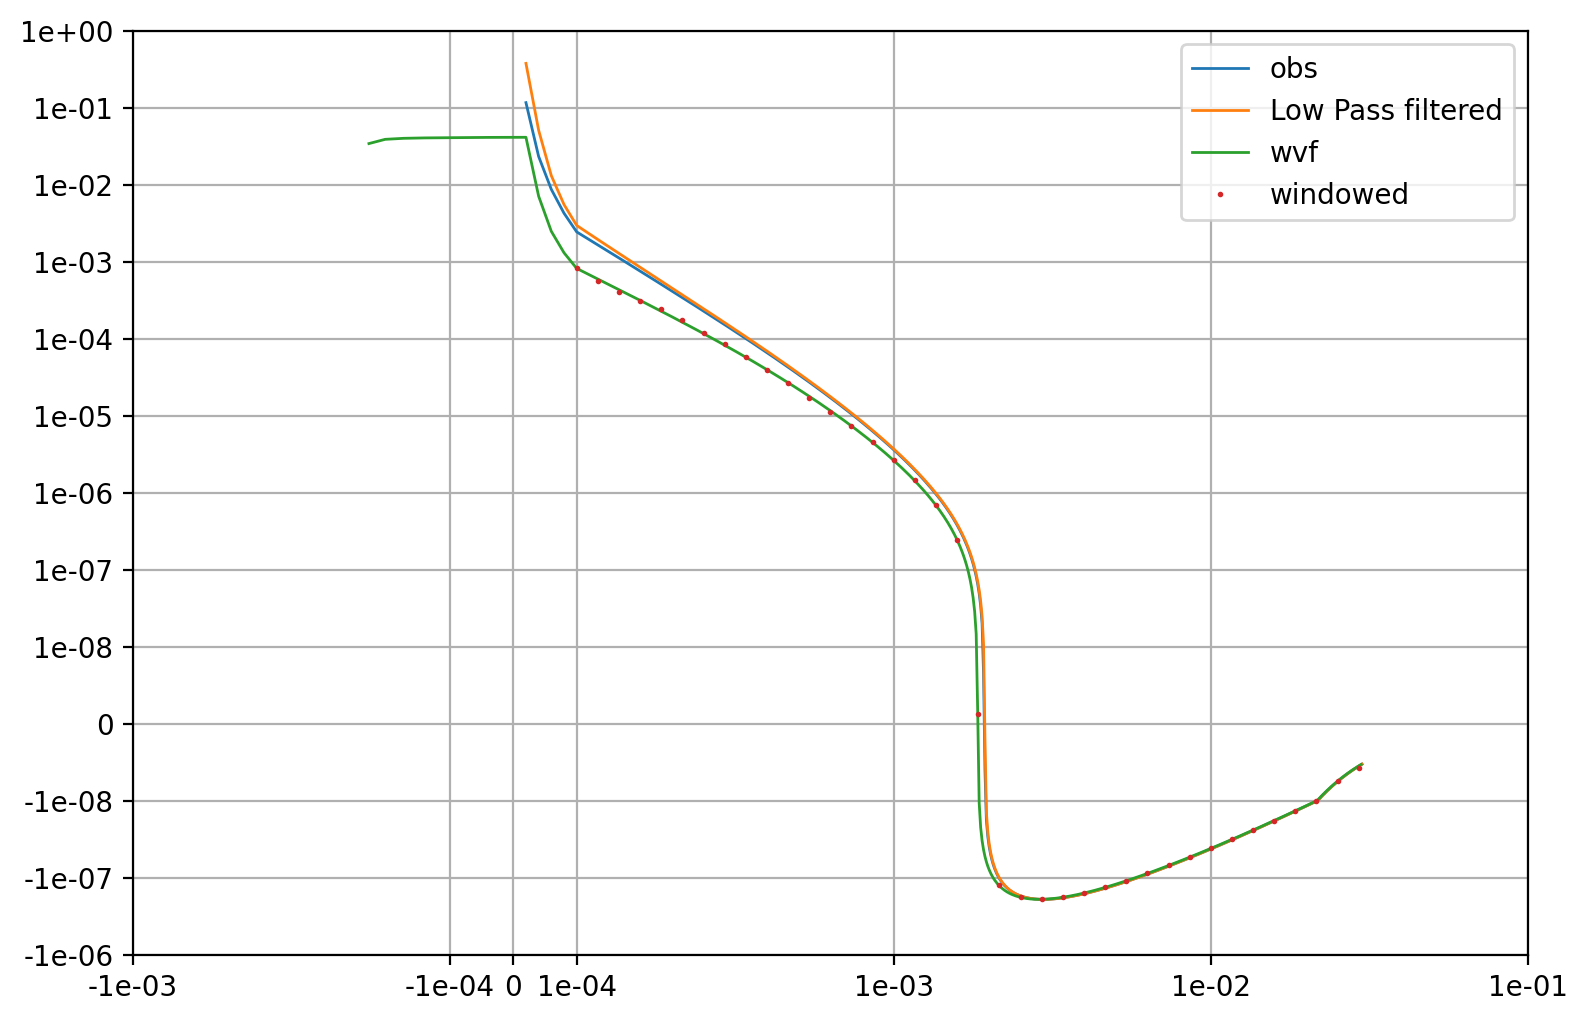

In [16]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [17]:
relative_error=0.05
data_noise_floor = 1e-8
dobs_clean =  sim_obs.dpred(mvec_obs)

# Calculate noise at each point according to the formula
np.random.seed(0)  # For reproducibility
noise_floor = data_noise_floor
noise_relative = relative_error * np.abs(dobs_clean)

# Combine the two sources of noise quadratically (in terms of variance)
total_noise = np.sqrt(noise_floor**2 + noise_relative**2)

# Add the combined noise to the clean data
dobs = dobs_clean +np.random.randn(len(dobs_clean)) *  total_noise
# data_init = sim_obs.predicted_data(mvec_ref)

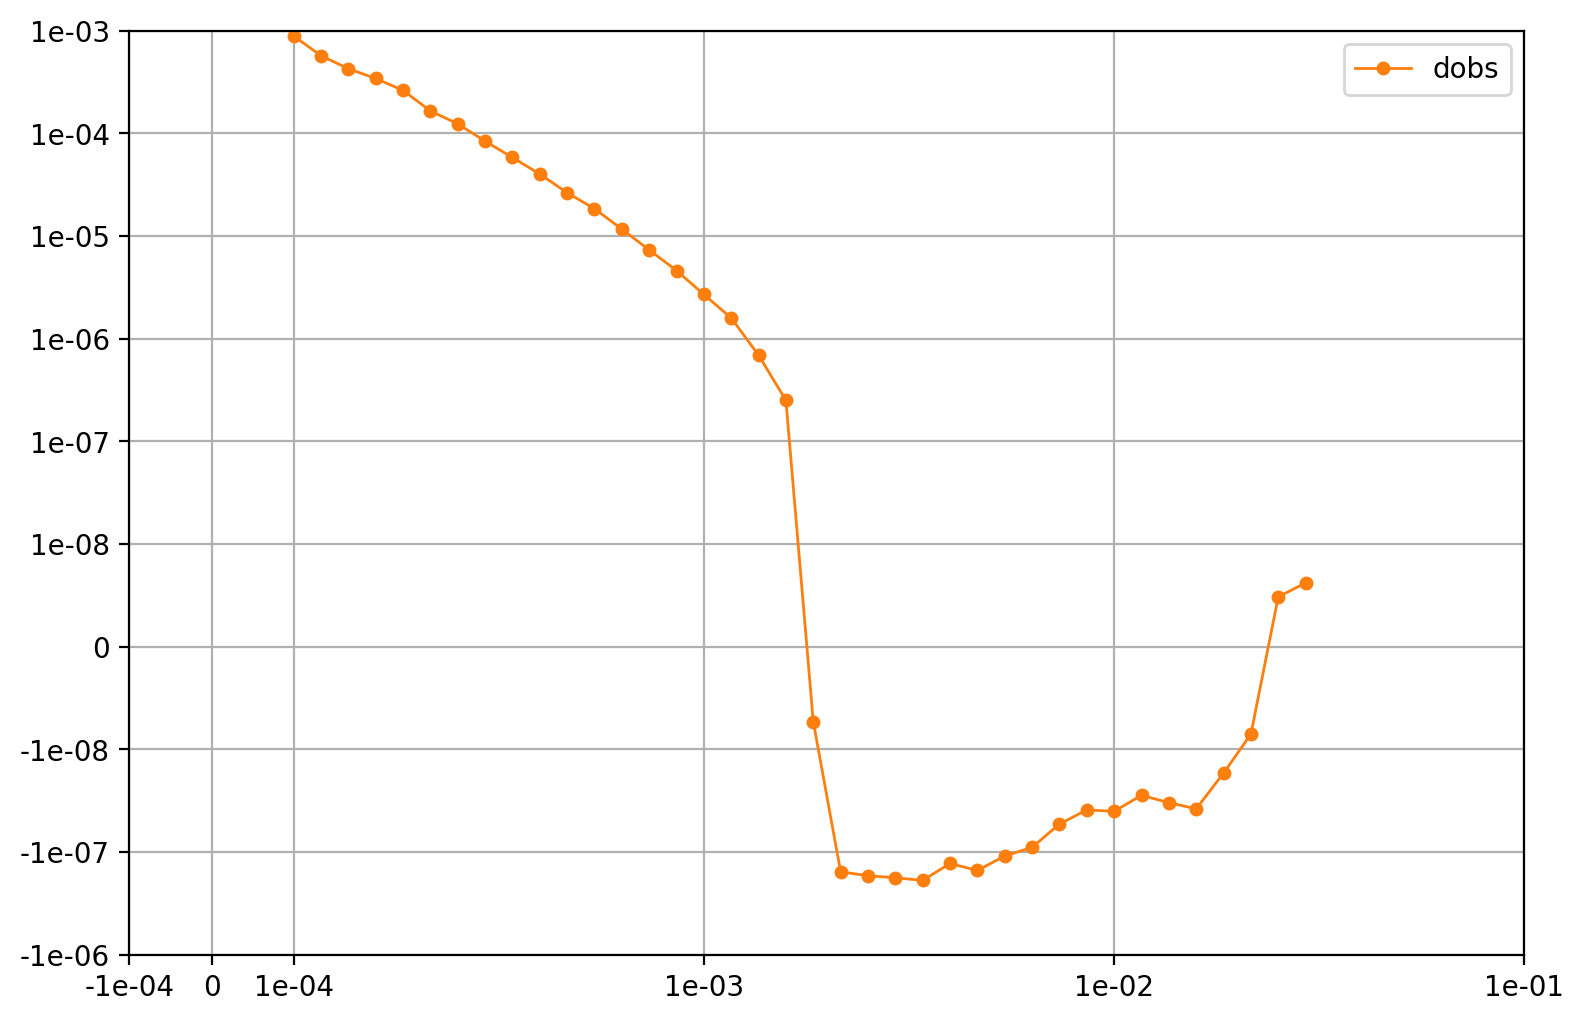

In [18]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
# ax=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=data_init,
#    label="ref/init", color="C0", marker="o",markersize=4,ax=ax
# )
ax=PL_decay.plpl_plot(x= windows_cen-rmp_time,y=dobs, 
   label="dobs", color="C1", marker="o",markersize=4,ax=ax
)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


# Invert with Debye Decomposition model

In [62]:

nrange=3
# taus_strt_log = np.r_[-3.5, -3.5, -3.5]
taus_strt_log = np.r_[-3.5, -3.5, -3.5]
taus_end_log  = np.r_[-2.5, -1.75, -1.0]
taus_end = 10**taus_end_log
taus_strt = 10**taus_strt_log
print(taus_end)
print(taus_strt)
taus_step_log = 0.25

taus_max, taus_min = taus_end_log.max(), taus_strt_log.min()


[0.00316228 0.01778279 0.1       ]
[0.00031623 0.00031623 0.00031623]


In [20]:

taus_cmb = []
m_refs = []
taus_colors = []
sim_inv = []
Wd_refs = []
J_refs = []
ntau_cmb= []
for i in range(nrange):
    taus= 10**np.arange(taus_strt_log[i], taus_end_log[i]+ taus_step_log, taus_step_log)
    ntau= len(taus)
    taus_color = (np.linspace(taus_strt_log[i], taus_end_log[i], ntau)-taus_min)/ (taus_max-taus_min)
    m_ref = np.r_[np.log(res_sea), np.zeros(ntau)]
    print(taus) 
    print(taus_color)
    taus_cmb.append(taus)
    ntau_cmb.append(ntau)
    taus_colors.append(taus_color)
    m_refs.append(m_ref)
    sim=empymod_IP_simulation(ip_model='DDR',chgmin=0,
        model_base=empymod_model_sim, nlayer=nlayer,tx_height=tx_height,
        taus=taus, times=times_sim, smp_freq=smp_freq
    )
    sim.deepsea_signle_layer(
        res_sea=res_sea, res_base=res_base, eta_sea=eta_sea, eta_base=eta_base  
        )
    dpred_step= sim.dpred(m_ref)
    sim.cut_off = smp_freq/2.0
    dpred_LPF = sim.dpred(m_ref)
    sim.filt_curr = filt_linrmp
    dpred_rmp = sim.dpred(m_ref)
    sim.window_mat=Window_mat
    dpred_window = sim.dpred(m_ref)
    sim_inv.append(sim) 
    opt = Optimization(sim=sim_inv[i], dobs=dpred_window)
    opt.get_Wd(ratio=relative_error, plateau=data_noise_floor )
    Wd_refs.append(opt.Wd)
    J_refs.append(sim_inv[i].J(m_ref))
Wd_ref = Wd_refs[0]
ntau_max = max(ntau_cmb)

[0.00031623 0.00056234 0.001      0.00177828 0.00316228]
[0.  0.1 0.2 0.3 0.4]
[0.00031623 0.00056234 0.001      0.00177828 0.00316228 0.00562341
 0.01       0.01778279]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7]
[0.00031623 0.00056234 0.001      0.00177828 0.00316228 0.00562341
 0.01       0.01778279 0.03162278 0.05623413 0.1       ]
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [21]:
U_ddr_refs = []
U_ddr_recs = []
S_ddr_refs = []
S_ddr_recs = []
V_ddr_refs = []
V_ddr_recs = []
Jprd_refs = []
Jprd_recs = []
J_refs = []
J_recs = []
for i in range(nrange):
    sim = sim_inv[i]
    Wd_ref = Wd_refs[i]
    m_ref = m_refs[i]
    jacobian = sim.J(m_ref)
    J_refs.append(jacobian)
    U, S, V = np.linalg.svd(Wd_ref@jacobian, full_matrices=False)
    U_ddr_refs.append(U)
    V_ddr_refs.append(V)
    s_norm = S/S.max()
    S_ddr_refs.append(s_norm)
    Jprd = sim.J_prd(Wd_ref@jacobian)
    Jprd_refs.append(abs(Jprd))

sim = sim_obs
jacobian = sim_obs.J(mvec_obs)
J_refs.append(jacobian)
U, S, V = np.linalg.svd(Wd_ref@jacobian, full_matrices=False)
U_ddr_refs.append(U)
V_ddr_refs.append(V)
s_norm = S/S.max()
S_pelton = s_norm
Jprd = sim_obs.J_prd(Wd_ref@jacobian)
Jprd_pelton = abs(Jprd)



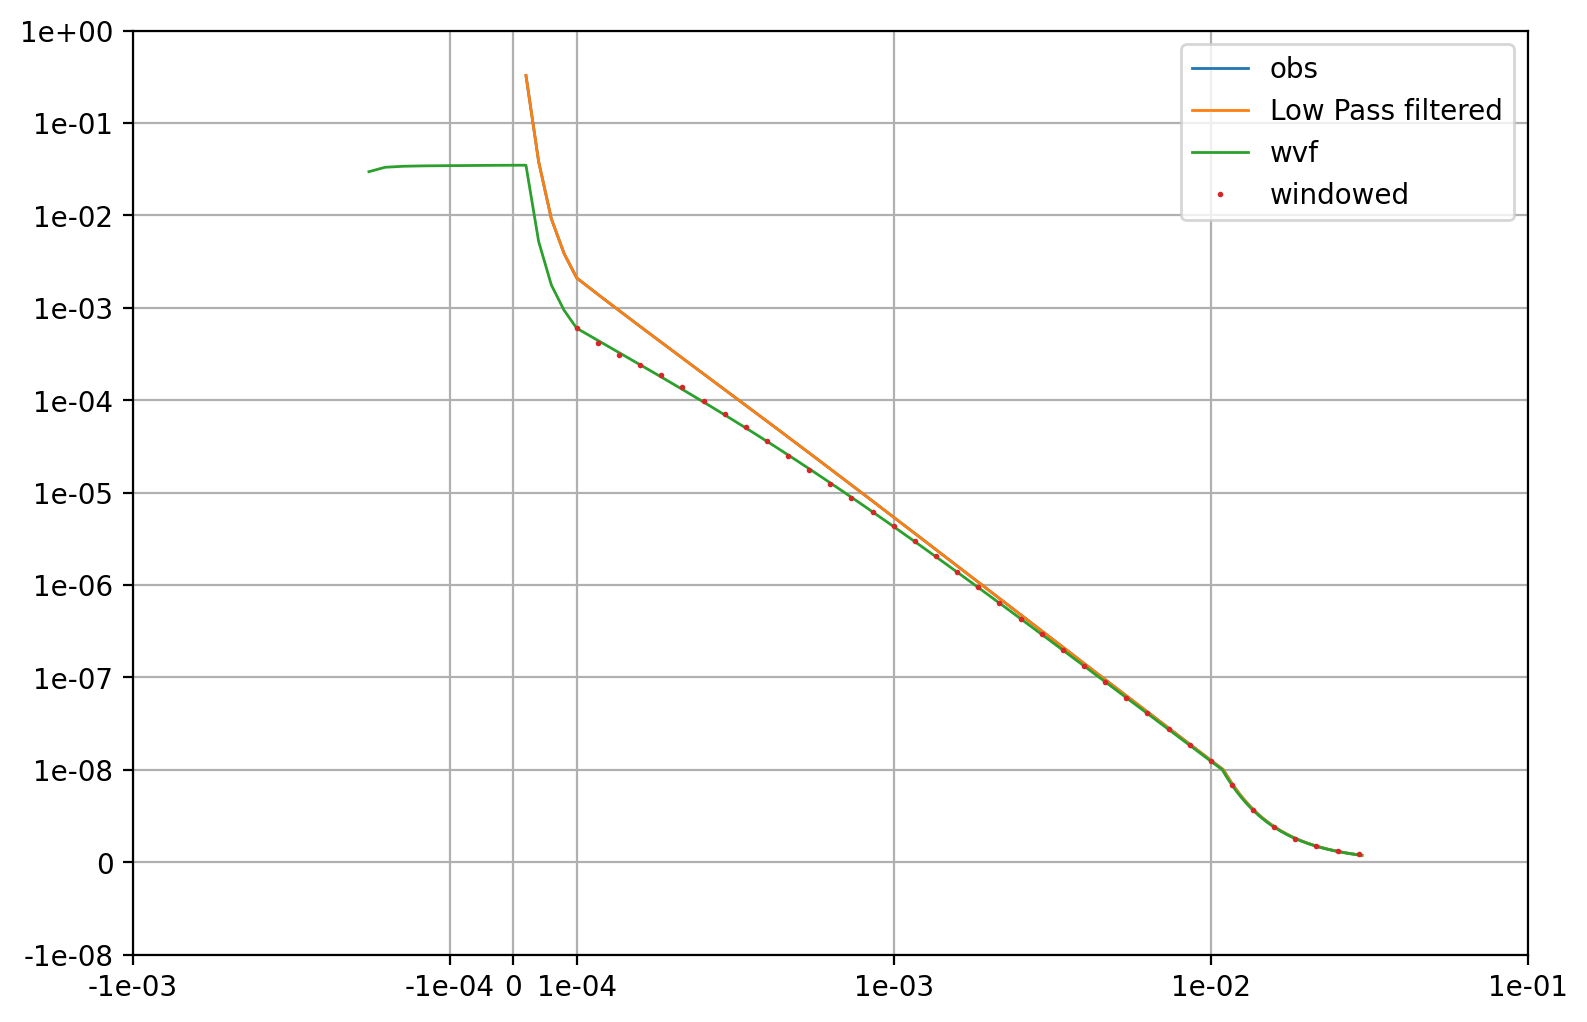

In [22]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)

ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_step , linestyle="-",label="obs", color="C0",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc,y=dpred_LPF , linestyle="-",label="Low Pass filtered", color="C1",ax=ax)
ax=PL_decay.plpl_plot(
     x=times_clc-rmp_time,y=dpred_rmp , linestyle="-",label="wvf", color="C2",ax=ax)
ax=PL_decay.plpl_plot(
     x= windows_cen-rmp_time,y=dpred_window , marker="o",linestyle="",label="windowed", color="C3",ax=ax)
ax= PL_decay.pl_axes(ax)
ax = PL_decay.pl_axes_x(ax)
#for ax in ax:
ax.grid()
ax.legend()


In [23]:
colormap = plt.get_cmap("hsv")

In [24]:
def plot_data(data_init, dpred, ax=None):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
       
    ax=PL_decay.semiply(windows_cen-rmp_time, data_init, ax=ax,
                       color="C1",label="ref" #
                       )
    ax=PL_decay.semiply(windows_cen-rmp_time, dpred, ax=ax
                        ,color="C0",linestyle="-",
                        label=f"est"# mated, iter={iteration}"
                        )
    ax=PL_decay.semiply(windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=2.0,
                       color="C2",linestyle="", label="obs"
                       )
    ax = PL_decay.pl_axes(ax)
    # ax.grid()
    # ax.legend()
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("EMF (V/A)")

#     ax.set_title(f""" Data plot
# Relative error {relative_error*100:.1f} %, noise floor {data_noise_floor:.1e}""")
    return ax

In [25]:
def plot_jacobian(irange,ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    taus = taus_cmb[irange]
    taus_color = taus_colors[irange]
    natu = ntau_cmb[irange]
    J_ref = J_refs[irange]
    Wd_ref = Wd_refs[irange]
    for j in range(natu):
        color = colormap(taus_color[j])
        ax=PL_jac.semiply(
        x= windows_cen-rmp_time,y=Wd_ref@J_ref[:,j+nlayer] ,color=color,
        linestyle="-",label=fr"$\eta_j, \tau_j: {taus[j]:.1e}$",ax=ax
        )
    ax=PL_jac.semiply(
        windows_cen-rmp_time, -Wd_ref@J_ref[:,0],color="k",label=r"-$\rho_0$",ax=ax,
            linestyle="--", linewidth=2#, marker="o",markersize=4
            )
    ax= PL_jac.pl_axes(ax)
    ax.set_title(fr"$W_dJ$ for model_{irange}")
    return ax

In [26]:
def plot_taus(irange,ax=None):
    if ax is None:
        fig , ax = plt.subplots(1,1, figsize=(5,3))

    taus = taus_cmb[irange]
    taus_color = taus_colors[irange]
    ntau = ntau_cmb[irange]
    for j in range(ntau):
        color = colormap(taus_color[j])
        ax.semilogx(taus[j], irange, 
            linestyle="", marker="o", color=color, markersize=4.0)
    ax.set_yticks(np.arange(0, nrange))
    ax.set_yticklabels([f"model_{i}" for i in range(nrange)])
    ax.invert_yaxis()
    ax.set_title(r"$\tau_j$ for each model")
    ax.set_xlabel(r"$\tau_j$ (s)")
    return ax

In [27]:
def plot_cnd(S,ax=None, label=None):
    if ax is None:
        fig , ax = plt.subplots(1,1, figsize=(5,3))
    ax.semilogy(S, linestyle="-", marker="o",
                   label=label) # max($\tau_j$): {tau_end:.2e}")
    ax.set_xticks(np.arange(ntau_max+1))
    ax.set_xticklabels(np.arange(1,ntau_max+2))
    ax.set_xlabel("Singular Value Index")
    ax.set_title("Condition Number")

    return ax

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


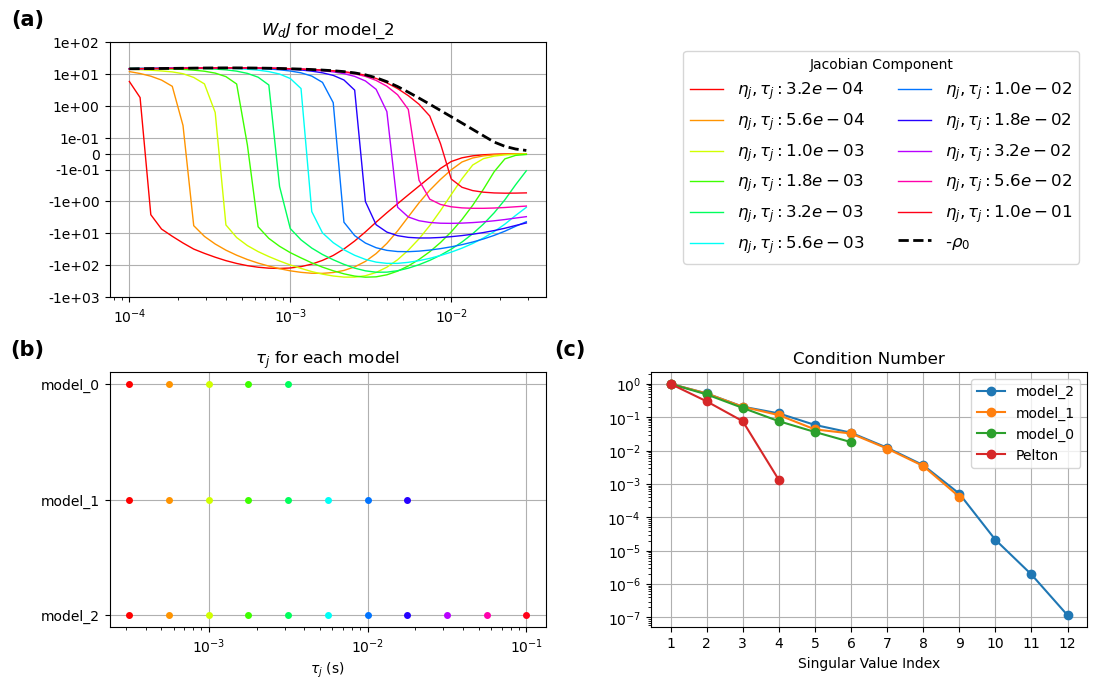

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(11,7))
ax_jacobian = ax[0, 0]
ax_cnd = ax[1, 1]
ax_tau = ax[1, 0]
ax_color =ax[0, 1]

taus = taus_cmb[2]
ntau = ntau_cmb[2]

ax_jacobian =  plot_jacobian(irange=2, ax=ax_jacobian)
for i in range(nrange-1,-1,-1):
    ax_cnd=plot_cnd(S_ddr_refs[i], ax=ax_cnd, label= f"model_{i}")
    ax_tau=plot_taus(irange=i, ax=ax_tau)
ax_cnd = plot_cnd(S_pelton, ax=ax_cnd, label="Pelton")

# ax_color=plot_color(ax=ax_color)

for a in ax.flatten():
    a.grid()

ax_cnd.legend()
ax_color.axis("off")
handles, labels = ax_jacobian.get_legend_handles_labels()
ax_color.legend(handles, labels, title="Jacobian Component",loc="upper right",ncol=2, fontsize=12)

axis_to_label = [ax_jacobian,ax_tau,ax_cnd]
panel_labels = ['(a)', '(b)', '(c)']
ax = ax.flatten()

for label, axis in zip(panel_labels, axis_to_label):
    axis.text(
        -0.15, 1.05, label,
        transform=axis.transAxes,
        fontsize=15, fontweight='bold',
        va='bottom', ha='right'
    )

plt.tight_layout()
#plt.savefig('43_DD_TEM_Jacobian.jpg', dpi=300)#

# Inversion: Single layer fixed thickness

In [29]:
niter = 50
stol=1e-6
coolingFactor = np.sqrt(2) #2.0
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [30]:
models_rec = []
dpreds = []
error_prgs = []
model_prgs = []
dinit_refs = []
data_prgs =[]
betas_prgs = []
for i in range(nrange):
    m_ref = m_refs[i]
    sim = sim_inv[i]
    opt = Optimization(sim=sim, dobs=dobs)
    opt.get_Wd(ratio=relative_error, plateau=data_noise_floor )
    opt.get_Ws(smallness=np.ones(len(m_ref)))
    beta0 = opt.BetaEstimate_byEig(
        mvec=m_ref, update_Wsen=True, beta0_ratio=beta0_ratio)
    print(beta0)
    mpred = opt.GaussNewton(
    mvec_init=m_ref,niter=niter,beta0=beta0, update_Wsen=True,
    stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
    )
    
    dinit_refs.append(opt.dpred(m_ref))
    models_rec.append(mpred)
    dpreds.append(opt.dpred(mpred))
    error_prgs.append(opt.error_prg)
    model_prgs.append(opt.mvec_prg)
    data_prgs.append(opt.data_prg)
    betas_prgs.append(opt.betas)


1370439842.5164757
  1, beta:1.4e+09, step:1.0e+00, g:4.1e+05, phid:1.3e+04, phim:9.2e-08, f:1.3e+04 
  2, beta:1.4e+09, step:1.0e+00, g:3.5e+02, phid:1.3e+04, phim:9.2e-08, f:1.3e+04 
  3, beta:9.7e+08, step:1.0e+00, g:1.2e+05, phid:1.2e+04, phim:1.8e-07, f:1.3e+04 
  4, beta:9.7e+08, step:1.0e+00, g:1.4e+02, phid:1.2e+04, phim:1.8e-07, f:1.3e+04 
  5, beta:6.9e+08, step:1.0e+00, g:1.2e+05, phid:1.2e+04, phim:3.6e-07, f:1.3e+04 
  6, beta:6.9e+08, step:1.0e+00, g:2.0e+02, phid:1.2e+04, phim:3.6e-07, f:1.3e+04 
  7, beta:4.8e+08, step:1.0e+00, g:1.2e+05, phid:1.2e+04, phim:7.1e-07, f:1.2e+04 
  8, beta:4.8e+08, step:1.0e+00, g:2.7e+02, phid:1.2e+04, phim:7.1e-07, f:1.2e+04 
  9, beta:3.4e+08, step:1.0e+00, g:1.2e+05, phid:1.2e+04, phim:1.4e-06, f:1.2e+04 
 10, beta:3.4e+08, step:1.0e+00, g:3.7e+02, phid:1.2e+04, phim:1.4e-06, f:1.2e+04 
 11, beta:2.4e+08, step:1.0e+00, g:1.1e+05, phid:1.1e+04, phim:2.7e-06, f:1.2e+04 
 12, beta:2.4e+08, step:1.0e+00, g:5.0e+02, phid:1.1e+04, phim:2.7e-

In [31]:
phid_star=len(windows_cen)
models_rec_phid = []
dpreds_phid = []
phid_star_ratio =1.0
phid_itrs = []
for i in range(nrange):
    model_prg= np.array(model_prgs[i])
    data_prg = np.array(data_prgs[i])
    error_prg = error_prgs[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        print("No phid star found, take min phid")
        ind = phid_prg == np.min(phid_prg)
    phid_itr = np.where(ind)[0][0]
    models_rec_phid.append(model_prg[ind][0])
    dpreds_phid.append(data_prg[ind][0])
    phid_itrs.append(phid_itr)


No phid star found, take min phid


In [32]:
print( "Parameter:  $\\rho_0$, $\\eta$, $\\tau_max$")
np_mvec_refs= []
np_mvec_ests= []
for i in range(nrange):
    np_mvec_ref = m_refs[i]
    # mvec_est = models_rec[i]
    mvec_est = models_rec_phid[i]
    taus_max = taus_cmb[i].max()
    np_mvec_refs.append(np_mvec_ref)
    np_mvec_ests.append(mvec_est)
    # print(f"ref{i+1}     & {np.exp(np_mvec_ref[0]):.2e} & {np_mvec_ref[1:].sum():.3f} ")
    # print(f"est{i+1}     & {np.exp(np_mvec_est[0]):.2e} & { np_mvec_est[1:].sum():.3f} & {taus_max:.2e}")
    print(f"est_phid{i+1}& {np.exp(mvec_est[0]):.2e} & {mvec_est[1:].sum():.3f} & {taus_max:.2e}")


Parameter:  $\rho_0$, $\eta$, $\tau_max$
est_phid1& 2.29e-01 & 0.132 & 3.16e-03
est_phid2& 2.69e-01 & 0.233 & 1.78e-02
est_phid3& 3.22e-01 & 0.370 & 1.00e-01


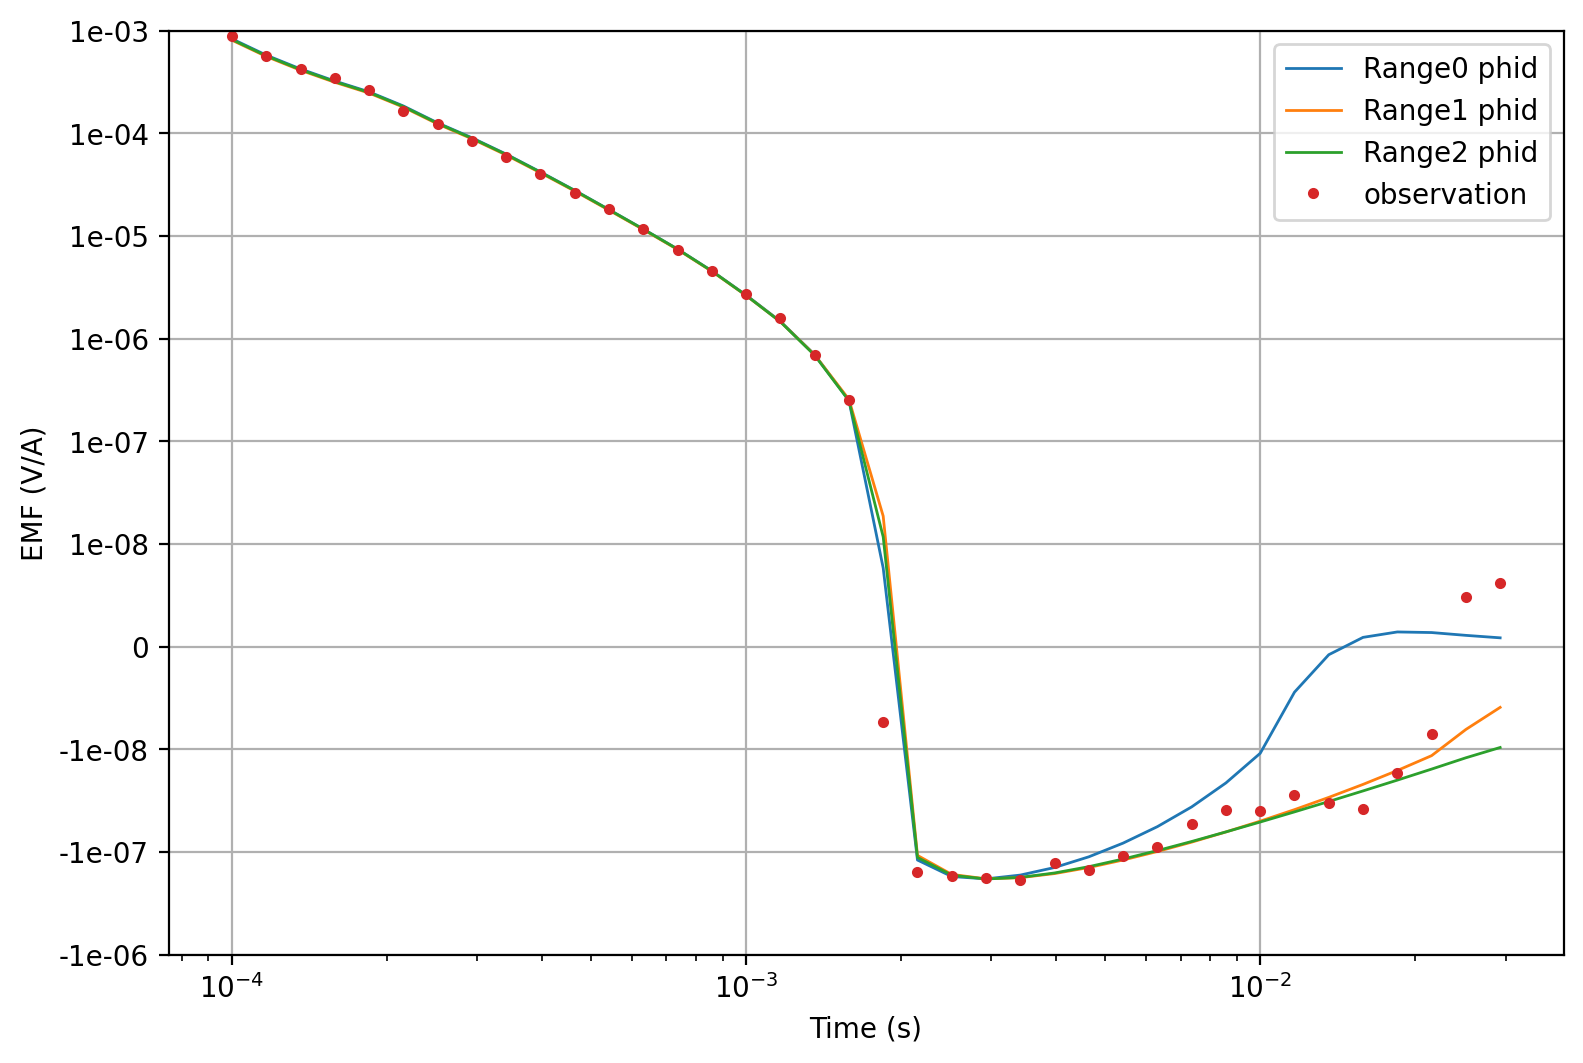

In [33]:
fig, ax= plt.subplots(1,1, figsize=(9,6), dpi=200)
for i in range(nrange):
    # ax=PL_decay.semiply(
    #     windows_cen-rmp_time, dpreds[i], ax=ax,
    #     color=f"C{i}",linestyle="-", label=f"Ref/Init{i+1}"
    #     )
    ax = PL_decay.semiply(
        windows_cen-rmp_time, dpreds_phid[i], ax=ax,
        color=f"C{i}",linestyle="-", label=f"Range{i} phid"
        )
ax=PL_decay.semiply(
    windows_cen-rmp_time, dobs, ax=ax, marker="o",markersize=3.0,
    color=f"C{nrange}",linestyle="", label="observation"
    )
ax = PL_decay.pl_axes(ax)
ax.grid()
ax.legend()
ax.set_xlabel("Time (s)")
ax.set_ylabel("EMF (V/A)")
plt.savefig("43_DD_TEM_dpreds.jpg", dpi=300)

# get SIP of target layer

In [34]:
freq_step_log  = 0.1
freq_cmb = []
freq_mins = []
freq_maxs = []
for i in range(nrange):
    taus
    freq = 10**np.arange(-taus_end_log[i], -taus_strt_log[i]+freq_step_log, freq_step_log)
    freq /= 2.0*np.pi
    freq_cmb.append(freq)
    freq_mins.append(freq.min())
    freq_maxs.append(freq.max())


In [35]:
freq_ext = 10.**np.arange(-1,5.1,0.1)   
IP_model = Pelton_res_f(freq=freq_ext)
sim_sip_ext = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
sip_true_ext= sim_sip_ext.dpred(mvec_obs)

In [36]:
relative_error = 0.05
noise_floor_ratio = 1e-3
niter = 100
stol=1e-6
coolingFactor = np.sqrt(2) # 2 
coolingRate = 2
mu=1e-3
beta0_ratio = 1.0

In [37]:
sip_trues =[]
sim_sip = []
sip_dpreds = []
model_recs_sip = []
dpreds_sip = []
error_prgs_sip = []
model_prgs_sip = []
dinit_refs_sip = []
data_prgs_sip =[]
betas_prgs_sip = []
for i in range(nrange):
    freq = freq_cmb[i]
    nfreq = len(freq)

    IP_model = Pelton_res_f(freq=freq)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    dobs_sip = sim.dpred(m=mvec_obs)
    sip_trues.append(dobs_sip)
    f_abs = abs(IP_model.f(mvec_obs))
    noise_floor= f_abs.max()*noise_floor_ratio

    taus = taus_cmb[i]
    ntau = ntau_cmb[i]

    IP_model = DDR_f(freq=freq,taus=taus)
    sim = InducedPolarizationSimulation(ip_model=IP_model, mode='sip')
    sim_sip.append(sim)
    sip_dpreds.append(sim.dpred(models_rec_phid[i]))
    
    mvec_ref = m_refs[i]
    opt = Optimization(sim=sim, dobs= dobs_sip)
    opt.get_Wd(ratio=relative_error, plateau=noise_floor)
    opt.get_Ws(np.ones(len(mvec_ref)))
    beta0 = opt.BetaEstimate_byEig(mvec=mvec_ref, update_Wsen=True)
    mpred = opt.GaussNewton(
        mvec_init=mvec_ref,niter=niter,beta0=beta0, update_Wsen=True,
        stol=stol,mu=mu,coolingRate=coolingRate, coolingFactor=coolingFactor
        )
    dinit_refs_sip.append(opt.dpred(mvec_ref))
    model_recs_sip.append(mpred)
    dpreds_sip.append(opt.dpred(mpred))
    error_prgs_sip.append(opt.error_prg)
    model_prgs_sip.append(opt.mvec_prg)
    data_prgs_sip.append(opt.data_prg)
    betas_prgs_sip.append(opt.betas)


  1, beta:7.3e+07, step:1.0e+00, g:8.1e+04, phid:2.3e+03, phim:7.7e-07, f:2.4e+03 
  2, beta:7.3e+07, step:1.0e+00, g:1.8e+02, phid:2.3e+03, phim:7.6e-07, f:2.4e+03 
  3, beta:5.2e+07, step:1.0e+00, g:2.3e+04, phid:2.3e+03, phim:1.5e-06, f:2.4e+03 
  4, beta:5.2e+07, step:1.0e+00, g:7.1e+01, phid:2.3e+03, phim:1.5e-06, f:2.4e+03 
  5, beta:3.7e+07, step:1.0e+00, g:2.3e+04, phid:2.2e+03, phim:2.9e-06, f:2.3e+03 
  6, beta:3.7e+07, step:1.0e+00, g:9.7e+01, phid:2.2e+03, phim:2.9e-06, f:2.3e+03 
  7, beta:2.6e+07, step:1.0e+00, g:2.2e+04, phid:2.2e+03, phim:5.5e-06, f:2.3e+03 
  8, beta:2.6e+07, step:1.0e+00, g:1.3e+02, phid:2.2e+03, phim:5.5e-06, f:2.3e+03 
  9, beta:1.8e+07, step:1.0e+00, g:2.2e+04, phid:2.1e+03, phim:1.0e-05, f:2.2e+03 
 10, beta:1.8e+07, step:1.0e+00, g:1.7e+02, phid:2.1e+03, phim:1.0e-05, f:2.2e+03 
 11, beta:1.3e+07, step:1.0e+00, g:2.1e+04, phid:1.9e+03, phim:1.9e-05, f:2.2e+03 
 12, beta:1.3e+07, step:1.0e+00, g:2.2e+02, phid:1.9e+03, phim:1.9e-05, f:2.2e+03 
 13,

In [38]:
phid_star_ratio = 1.0
sip_true_inv = []
sip_true_dpred = []
for i in range(nrange):
    sim = sim_sip[i]
    freq = freq_cmb[i]
    taus = taus_cmb[i]
    nfreq = freq.shape[0]
    phid_star = nfreq*2
    model_prg= np.array(model_prgs_sip[i])
    data_prg = np.array(data_prgs_sip[i])
    error_prg = error_prgs_sip[i]
    phid_prg = np.array(error_prg)[:,1]
    ind = phid_prg < phid_star*phid_star_ratio
    if np.sum(ind) == 0:
        ind = phid_prg == np.min(phid_prg)
    sip_true_inv.append(model_prg[ind][0])
    sip_true_dpred.append(data_prg[ind][0])


In [39]:
def plot_sip(freq, dpreds, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=(5,3))
    nfreq = len(freq)

    default_kwargs = {
        "linestyle": "-",
        "color": "C0",
        "linewidth": 1.0,
        "marker": None,
        "markersize": 1,
    }
    default_kwargs.update(kwargs)
    nfreq = len(dpreds)//2

    sip_real = dpreds[:nfreq]
    sip_imag = dpreds[nfreq:]
    sip_abs = np.abs(sip_real + 1j * sip_imag)
    sip_phs = np.angle(sip_real + 1j * sip_imag, deg=True)
    ax[0].semilogx(freq, sip_abs, **default_kwargs)
    ax[1].semilogx(freq, sip_phs, **default_kwargs)

    ax[0].set_ylim(bottom=0)
    ax[0].set_ylabel(r'$|\rho^{\ast}|~(\Omega\cdot\mathrm{m})$')
    ax[1].set_ylabel(r'$\phi~(^\circ)~(\mathrm{deg}) $')
    for a in ax:
        a.set_xlabel("Frequency [Hz]")

    return ax

In [40]:
def plot_etas_model(model,taus, ax=None, **kwargs):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5,3))
    etas = model[1:]

    ax.semilogx(taus, etas, **kwargs)
    ax.set_xlabel(r"$\tau_k$ [s]")
    ax.set_ylabel(r"$\eta_k$")
    return ax

In [55]:
# title_heads= ['model_1', 'model_2', 'model_3']
title_heads = []
for i in range(nrange):
    title_head = fr'$max(\tau_k)$: {taus_end[i]:.1e}'
    title_heads.append(title_head)
print(title_heads)

['$max(\\tau_k)$: 3.2e-03', '$max(\\tau_k)$: 1.8e-02', '$max(\\tau_k)$: 1.0e-01']


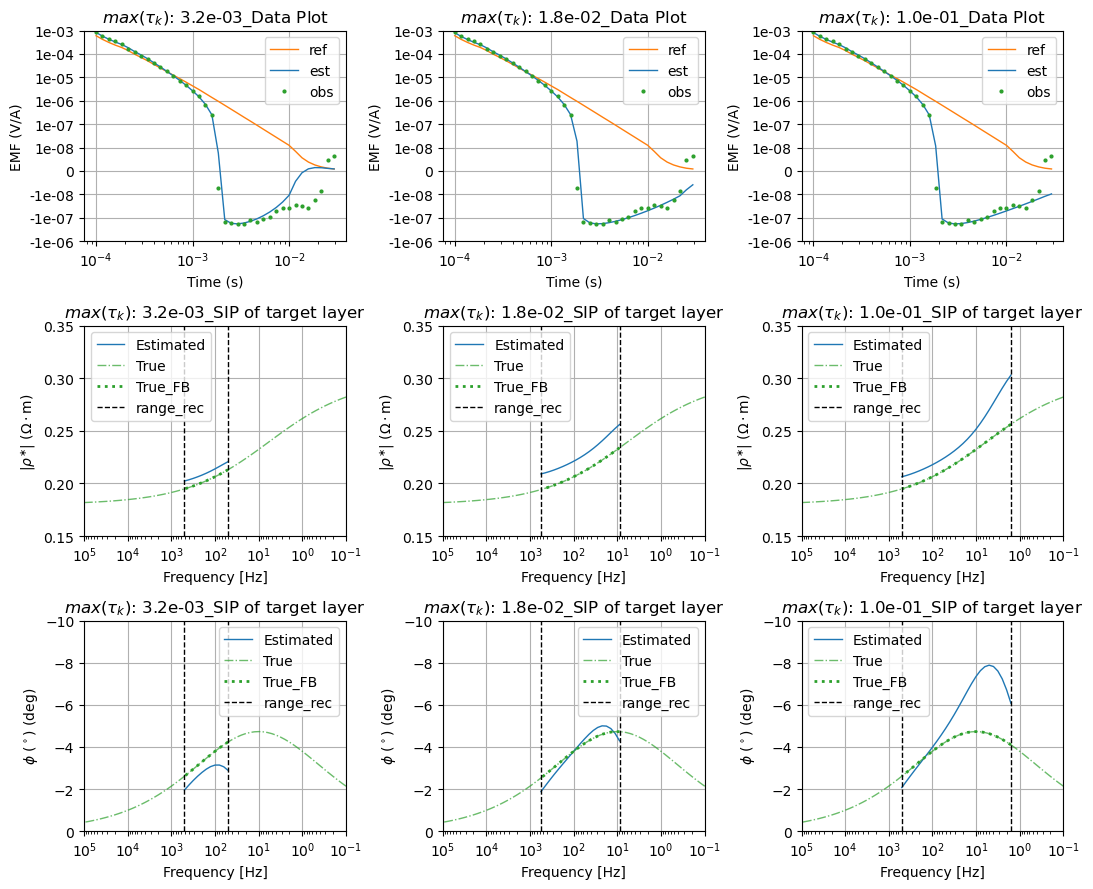

In [59]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nrange):
    title_head= title_heads[i]
    phid_itr = phid_itrs[i]
    sim = sim_sip[i]
    ax_range = ax_ranges[i]
    axdata = ax_range[0]
    axsip = [ax_range[1], ax_range[2]]
    axdata = plot_data(data_init = dinit_refs[i], dpred=dpreds_phid[i], ax=axdata)  
    axsip = plot_sip(freq_cmb[i], sip_dpreds[i], 
             ax=axsip, color="C0", label=f"Estimated", linestyle="-"
             )
    axsip  = plot_sip(freq=freq_ext,
              dpreds=sip_true_ext,ax=axsip, color="C2", label=f"True", linestyle="-.",
              alpha=0.7
              )
    axsip  = plot_sip(freq=freq_cmb[i],
              dpreds=sip_trues[i],ax=axsip, color="C2", label=f"True_FB", linestyle=":",
              linewidth=2.0)
    axsip[0].set_ylim(bottom=0.15,top=0.35)
    axsip[1].set_ylim(top=-10, bottom=0)
    axsip[0].axvline(x=freq_mins[i], color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[0].axvline(x=freq_maxs[i], color='k', linestyle='--', linewidth=1.0)
    axsip[1].axvline(x=freq_mins[i], color='k', linestyle='--', linewidth=1.0,
                     label=f"range_rec"
                     )
    axsip[1].axvline(x=freq_maxs[i], color='k', linestyle='--', linewidth=1.0)


    for a in axsip:
        a.set_xlim(left=1e5, right=0.1)

    for a in ax_range:
        a.legend()#(bbox_to_anchor=(1.05, 1), loc='upper left')
        a.grid()
    ax_range[0].set_title(f"{title_head}_Data Plot")
    ax_range[1].set_title(f"{title_head}_SIP of target layer")
    ax_range[2].set_title(f"{title_head}_SIP of target layer")

plt.tight_layout()
plt.savefig('43_DD_data_rec.jpg', dpi=300)

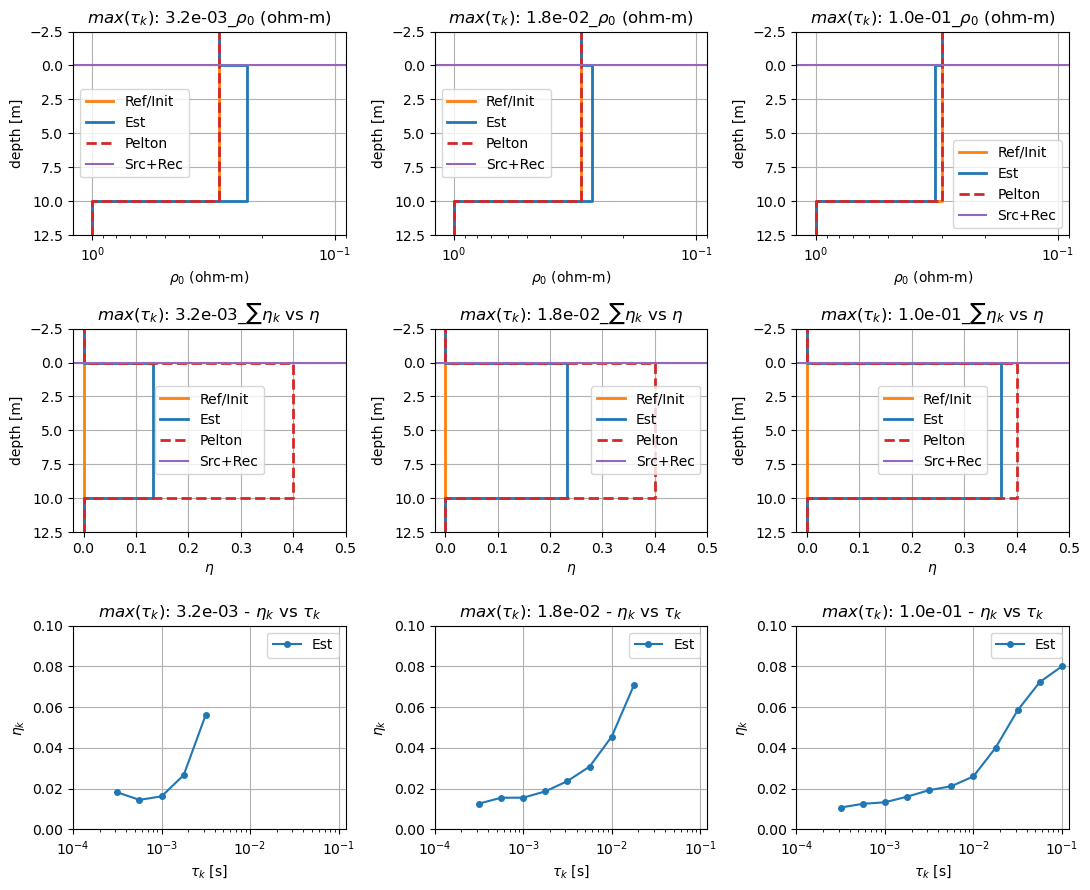

In [60]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nrange):
    title_head = title_heads[i]
    ax_range = ax_ranges[i]
    axrm = ax_range[0:2]
    axetas = ax_range[2]
    sim = sim_sip [i]
    m_ref = m_refs[i]
    axrm = sim_inv[i].plot_IP_par(mvec=m_ref, rm=True,
        label="Ref/Init", color=f"C1", linestyle="-",
        ax=axrm, linewidth=2.0)
    axrm = sim_inv[i].plot_IP_par(mvec=models_rec_phid[i], rm=True,
        label="Est", color=f"C0", linestyle="-", 
        ax=axrm, linewidth=2.0)
    rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    # label = fr"Est $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    axetas = plot_etas_model(models_rec_phid[i], taus_cmb[i],
             ax=axetas, color="C0",
             label="Est",
            linestyle="-", marker='o', markersize=4
             )
    # axrm = sim_inv[i].plot_IP_par(mvec=sip_true_inv[i], rm=True,
    #         label="Reconciled", color=f"C2", linestyle=":",
    #         ax=axrm, linewidth=3.0)
    axrm = sim_obs.plot_IP_par(mvec=mvec_obs, rm=True,
            label="Pelton", color=f"C3", linestyle="--",
            ax=axrm, linewidth=2.0)

    rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"Rec $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    # axetas = plot_etas_model(sip_true_inv[i], taus_cmb[i],
    #          ax=axetas, color="C2", label="Rec",
    #          linestyle=":", marker='.', markersize=3)
    axrm[0].invert_xaxis()
    axrm[0].set_xlim([1.2,0.09])
    axrm[1].set_xlim(right=0.5)
    axrm[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axrm[1].set_title(fr"{title_head}_$\sum\eta_k$ vs $\eta$")
    axetas.set_title(fr"{title_head} - $\eta_k$ vs $\tau_k$")
    axetas.set_xlim([1e-4,1.2e-1])
    axetas.set_ylim([0,0.1])
    for j , a in enumerate(axrm):  # Iterate over rows
        a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth [m]')
        if j== 0:
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    for a in (ax_range):
        a.grid()
        a.legend()
\
plt.tight_layout()
plt.savefig('43_Recovered_pelton.jpg', dpi=300)

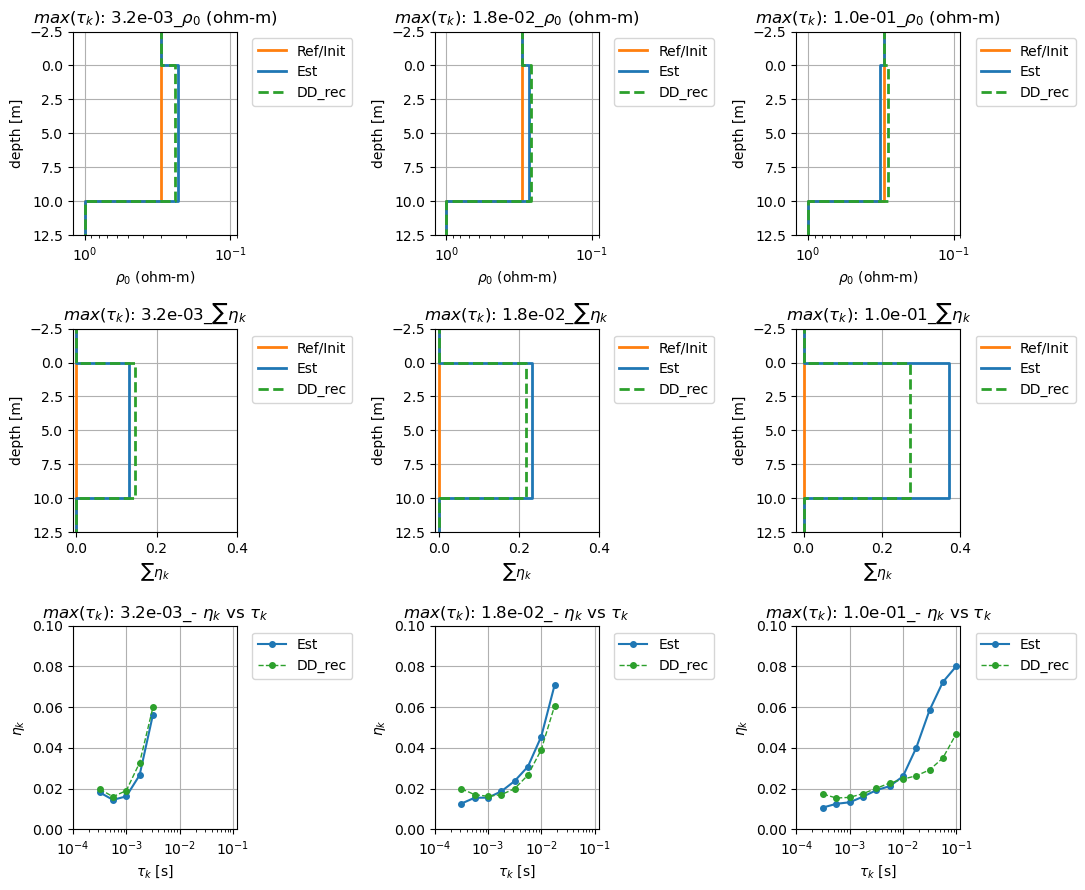

In [61]:
fig, ax = plt.subplots(3, 3, figsize=(11,9))

ax_ranges = []
ax_ranges.append([ax[0, 0], ax[1, 0], ax[2, 0]])
ax_ranges.append([ax[0, 1], ax[1, 1], ax[2, 1]])
ax_ranges.append([ax[0, 2], ax[1, 2], ax[2, 2]])
for i in range(nrange):
    title_head = title_heads[i]
    ax_range = ax_ranges[i]
    axrm = ax_range[0:2]
    axetas = ax_range[2]
    sim = sim_sip [i]
    m_ref = m_refs[i]
    axrm = sim_inv[i].plot_IP_par(mvec=m_ref, rm=True,
        label="Ref/Init", color=f"C1", linestyle="-",
        ax=axrm, linewidth=2.0)
    axrm = sim_inv[i].plot_IP_par(mvec=models_rec_phid[i], rm=True,
        label="Est", color=f"C0", linestyle="-", 
        ax=axrm, linewidth=2.0)
    rho0,eta = sim.ip_model.get_rho_eta(models_rec_phid[i])
    # label = fr"Est $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    axetas = plot_etas_model(models_rec_phid[i], taus_cmb[i],
             ax=axetas, color="C0",
             label="Est",
            linestyle="-", marker='o', markersize=4
             )
    axrm = sim_inv[i].plot_IP_par(mvec=sip_true_inv[i], rm=True,
            label="DD_rec", color=f"C2", linestyle="--",
            ax=axrm, linewidth=2.0)

    rho0,eta = sim.ip_model.get_rho_eta(sip_true_inv[i])
    # label = fr"Rec $\rho_0$:{rho0: .1e},$\eta$:{eta: .2f}"

    axetas = plot_etas_model(sip_true_inv[i], taus_cmb[i],
             ax=axetas, color="C2", label="DD_rec",
             linestyle="--", linewidth=1.0,
             marker='o', markersize=4)
    axrm[0].invert_xaxis()
    axrm[0].set_xlim([1.2,0.09])
    axrm[1].set_xlim(right=0.4)
    axrm[0].set_title(fr"{title_head}_$\rho_0$ (ohm-m)")
    axrm[1].set_title(fr"{title_head}_$\sum\eta_k$")
    axetas.set_title(fr"{title_head}_- $\eta_k$ vs $\tau_k$")
    axetas.set_xlim([1e-4,1.2e-1])
    axetas.set_ylim([0,0.1])
    for j , a in enumerate(axrm):  # Iterate over rows
        # a.axhline(empymod_model_sim["src"][4], color=f"C4", linestyle="-", label="Src+Rec")
        a.set_ylim([12.5, -2.5])
        a.set_ylabel('depth [m]')
        if j== 0:
            a.set_xscale("log")
        else:
            a.set_xscale("linear")
    for a in (ax_range):
        a.grid()
        a.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('43_Recovered_DD.jpg', dpi=300)